In [1]:
import ee
import datetime
import os
import itertools
import sys
import collections

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

# append module folter path into sys-path so wen can import necessary modules
sys.path.append('../Process_2_GEE_Python_Classification/')

In [3]:
from BackGround_modules.Class_1_Make_fourier_imgs import Make_Fourier
from BackGround_modules.Class_2_Classify_Fourier_Img import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Fig_Fourier_Making

In [4]:
# Instantiate the Fourier_class
Fourier_2018_2019 = Make_Fourier('2018-01-01','2019-01-01')

# Making the Fourier map
Fourier_2018_2019.Stp_1_Create_hamonic_names()
Fourier_2018_2019.Stp_2_Add_harmonics()
Fourier_2018_2019.Stp_3_Harmonic_fit()

Analyzing the images of 2018_2019


In [5]:
Fig_pt = ee.Geometry.Point(115.52126, 33.64591)

##### Get the Fourier img value

In [6]:
# get the Fourier_img
Fourier_img = Fourier_2018_2019.harmonicTrendCoefficients

# get the value of Foutire img at Fig_pt, 
#recall that the img was multipied by 1000 and converted into an integer
Fig_pt_img_value = ee.ImageCollection(Fourier_img).getRegion(Fig_pt, 30).getInfo()

##### Get the original_NDVI_NDBI_EVI

In [7]:
# get the original_value series
original_series = Fourier_2018_2019.harmonicLandsat.select(['NDVI','NDBI','EVI']).getRegion(Fig_pt, 30).getInfo()

# conver the original_series to a df and the original time to Y-m-d
original_series_df = pd.DataFrame(original_series[1:],columns=original_series[0])
original_series_df['time'] = pd.to_datetime(original_series_df['time'],unit='ms').dt.strftime('%Y-%m-%d')

original_series_df.sort_values('time',inplace=True)
original_series_df.index = range(len(original_series_df))

##### Get the fitted_NDVI_NDBI_EVI

In [12]:
# get the fitted_value series
fitted_series = Fourier_2018_2019.fittedHarmonic

In [13]:
# innitiate an empty df to hold both Fitted values
Fitted_value = pd.DataFrame()

for name in ['NDVI','NDBI','EVI']:
    
    # get the fitted_value series
    fitted_value = fitted_series[name].select([f'fitted_{name}']).getRegion(Fig_pt, 30).getInfo()

    # conver the original_series to a df and the original time to Y-m-d
    fitted_value_df = pd.DataFrame(fitted_value[1:],columns=fitted_value[0])
    fitted_value_df.sort_values('time',inplace=True)
    fitted_value_df.index = range(len(fitted_value_df))
    
    # concat original value with fitted value
    Fitted_value = pd.concat([Fitted_value,fitted_value_df[[f'fitted_{name}']]],axis=1,ignore_index=True)

##### Combine Original_value and Fitted_Value

In [34]:
# add column names to fitter values
Fitted_value.columns = ['Fit_NDVI','Fit_NDBI','Fit_EVI']

# concate Original and Fitted value into one df
Original_Fitted = pd.concat([original_series_df,Fitted_value],axis=1)


In [35]:
# create a fucntion that conver YMD to Year-fraction
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [38]:
# Add 'Y_fraction' to Original_Fitted
Original_Fitted['Y_fraction'] = pd.to_datetime(Original_Fitted['time']).apply(lambda x: toYearFraction(x))

# get the coefficient
Harmonic_coeficient = dict(zip(Fig_pt_img_value[0],Fig_pt_img_value[1]))

# wirte the reult to localdrive and read it
#Original_Fitted.to_csv('./Calculationg_result/Fig_1_Original_Fitted.csv',index = False)
Original_Fitted = pd.read_csv('./Calculationg_result/Fig_1_Original_Fitted.csv')

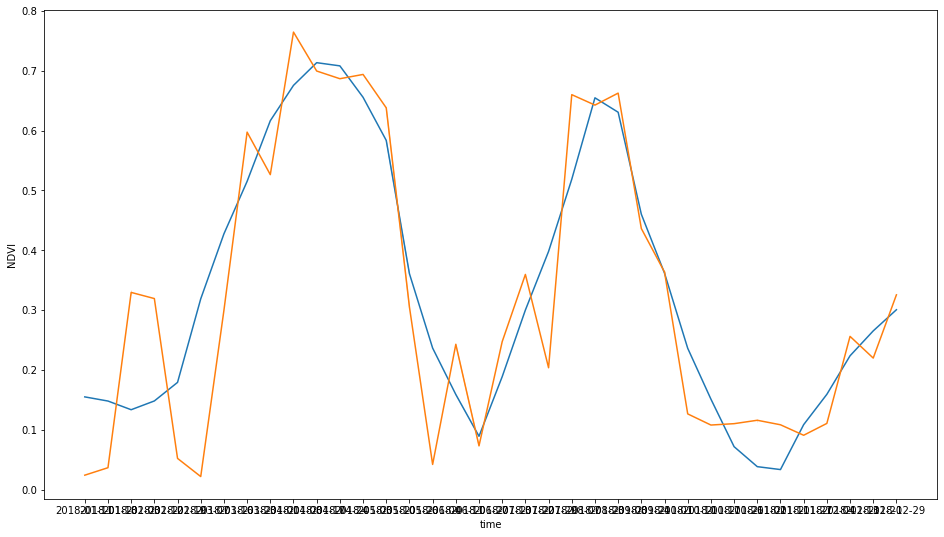

In [55]:
plt.figure(figsize=(16,9))
sns.lineplot(x='time',y='Fit_NDVI',data=Original_Fitted)
sns.lineplot(x='time',y='NDVI',    data=Original_Fitted)

### Restore fitted_sin_cos

##### Create independents using time

In [41]:
# Using time as dependendts
sin_cos_t = {}

interval = np.arange(2018,2019,0.02)

# using a 4-level loop to create time variables  
for idx in ['EVI','NDBI','NDVI']:    
    for s_c in ['cos','sin']:        
        for harmonic in [1,2,3]:
            for t in interval:
                
                sin_cos_t[(t,idx,'t','t')]       = (t-1970)*2*3.1415926
                sin_cos_t[(t,idx,'constant','constant')] = 1
                
                if   s_c == 'sin':
                    sin_cos_t[(t,idx,s_c,harmonic)]  = [math.sin(harmonic*t*2*3.1415926)]
                elif s_c == 'cos':
                    sin_cos_t[(t,idx,s_c,harmonic)]  = [math.cos(harmonic*t*2*3.1415926)]
                

In [42]:
# put sin_cos_t into a df
sin_cos_df = pd.DataFrame(sin_cos_t).T
sin_cos_df = sin_cos_df.unstack([2,3])

column_drop = sin_cos_df.columns.droplevel(0)
sin_cos_df.columns = column_drop

# re-order the df so shat it have the same order with coefficient
sin_cos_df = sin_cos_df[[('cos', 1),('cos', 2),('cos', 3),
                         ('sin', 1),('sin', 2),('sin', 3),
                         ('constant', 'constant'),
                         ('t', 't')]]

##### Create coefficients using Fourier_map values

In [21]:
Dict_coff = {}

for idx in ['EVI','NDBI','NDVI']:
    Dict_coff[idx] = [Harmonic_coeficient[key] for key in Harmonic_coeficient.keys() if idx in key]
    
Coff_df = pd.DataFrame(Dict_coff).T

# make the coefficient_df and sin_cos_df the same shape
Coff_df_repeat = pd.concat([Coff_df]*len(interval))

##### Restore the fitted values by [sin_cos_df] * [Coff_df_repeat]

In [47]:
# get the result by multiply sin_cos value with coefficient value
Fitted_sin_cos    = np.array(sin_cos_df) * np.array(Coff_df_repeat)
Fitted_sin_cos_df = pd.DataFrame(Fitted_sin_cos,index   =  sin_cos_df.index,
                                                columns =  [f'cos_{i}' for i in range(1,4)] 
                                                         + [f'sin_{i}' for i in range(1,4)] 
                                                         + ['constant','t'])
# sum the value of [sin_cos_df] * [Coff_df_repeat]
# which will be the fitted value
Fitted_sin_cos_df['sum'] = Fitted_sin_cos_df.sum(axis=1)
Fitted_sin_cos_df = Fitted_sin_cos_df.unstack()

In [58]:
Fitted_sin_cos_df.to_csv(r'C:\Users\wangj\Desktop\New folder\tmp.csv')

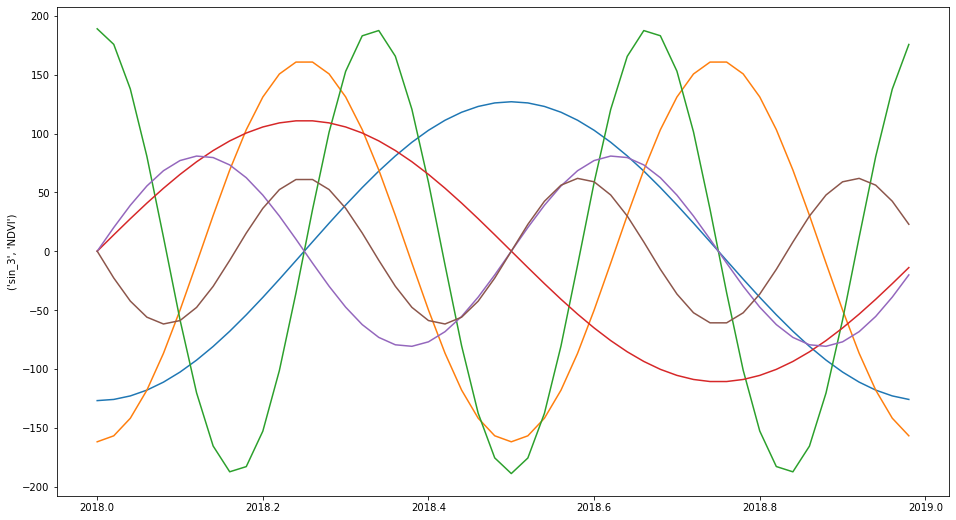

In [54]:
plt.figure(figsize=(16,9))

# plot each sin_cos waves 
for sin_cos in [f'cos_{i}' for i in range(1,4)] + [f'sin_{i}'for i in range(1,4)]:
    for idx in ['NDVI']:
        sns.lineplot(x=Fitted_sin_cos_df.index,y=(sin_cos,idx),data=Fitted_sin_cos_df)

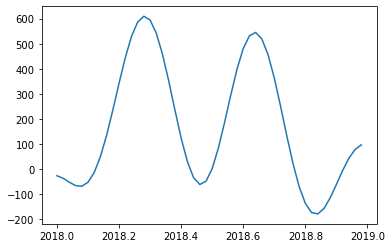

In [23]:
Fitted_sin_cos_df.unstack()[('sum','EVI')].plot()

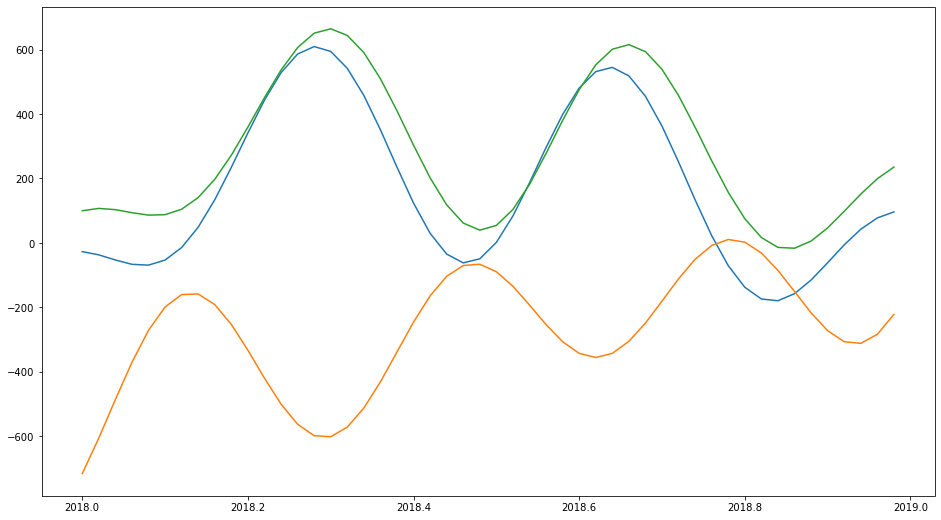

In [56]:
plt.figure(figsize=(16,9))
Fitted_sin_cos_df.unstack()[('sum','EVI')].plot()
Fitted_sin_cos_df.unstack()[('sum','NDBI')].plot()
Fitted_sin_cos_df.unstack()[('sum','NDVI')].plot()

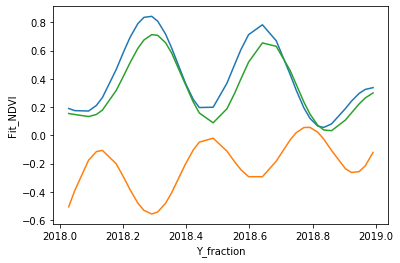

In [25]:
sns.lineplot(x='Y_fraction',y='Fit_EVI',data=Original_Fitted)
sns.lineplot(x='Y_fraction',y='Fit_NDBI',data=Original_Fitted)
sns.lineplot(x='Y_fraction',y='Fit_NDVI',data=Original_Fitted)